In [1]:
%load_ext autoreload
%autoreload 2

import sys, warnings, glob, datetime
import xwmt, xwmb, xgcm, regionate, xbudget

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns
import cmocean.cm as cmo
import matplotlib.gridspec as gridspec
import pandas as pd


dpi = 100
mpl.rcParams['figure.dpi'] = dpi
sns.set_theme(context='notebook', style='ticks')

sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *

from SWMT_decomposition import *
from ant_plots import *
from isopycnal_plot_formatting import *
from select_max_loc import *
from spatial_decompostion import *

In [13]:
def get_variable_spatial_decompose(mean_swmt, var = "SWMT"): 
    ds_decomp = decompose_discrete_full(
    mean_swmt[reference_period][var], mean_swmt[pert_period][var],
    dims=("xh", "yh"))
    return ds_decomp

def get_variable_spatial_sum_reference(mean_swmt, var = "SWMT"): 
    return mean_swmt[reference_period][var].sum(dim=("xh", "yh"))
    
def get_variable_spatial_sum_pert(mean_swmt, var = "SWMT"): 
    return mean_swmt[pert_period][var].sum(dim=("xh", "yh"))
    
def get_variable_integrand_change(mean_swmt, var = "SWMT"): 
    ds_decomp = get_variable_spatial_decompose(mean_swmt, var)
    return ds_decomp["integrand_change"]

def add_bar_numbers(bars, ax, text_height_factor = 2):
    # Grab the color of the bars so we can make the
    # text the same color.
    
    
    # Add text annotations to the top of the bars.
    # Note, you'll have to adjust this slightly (the 0.3)
    # with different data.
    for bar in bars:
        bar_color = bar.get_facecolor()
        height_diff = np.sign(bar.get_height()) * text_height_factor
        ax.text(
          bar.get_x() + bar.get_width() / 2,
          bar.get_height() + height_diff,
          round(bar.get_height(), 2),
          horizontalalignment='center',
          color=bar_color,
          weight='bold'
    )

In [2]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client

log_directory="/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/WaterMassBudgets/logs"

cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='50GB',
    walltime='04:00:00',
    queue='scavenger',
    interface='ib0', 
log_directory = log_directory)
print(cluster.job_script())
cluster.scale(jobs=12)

client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.err
#SBATCH -o /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.out
#SBATCH -p scavenger
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=47G
#SBATCH -t 04:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.70:37209 --name dummy-name --nthreads 36 --memory-limit 46.57GiB --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.70:37209,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [58]:
formula_variable = "x^2 + y^2"
latex_formula = f"The equation is: $\\int_{{0}}^{{1}} {formula_variable} \\, dx$"
print(latex_formula)

The equation is: $\int_{0}^{1} x^2 + y^2 \, dx$


### Load in data

In [3]:
reference_period = '1980-2020'
pert_period = '2075-2100'

In [4]:
savedir = "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/"
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/" + x

In [5]:
ds = xr.open_dataset(datadir("/model/Southern_Ocean_50S_WMT_Budget.nc"))
ds = ds.groupby("time.year").mean("time")
ds_SWMT = get_SWMT(ds)

In [6]:
ds_sfc = xr.open_mfdataset(datadir(f"/model/Southern_Ocean_50S_Surface_Fluxes_sigma_slice.nc"))
# ds_sfc = ds_sfc.where(ds_sfc.geolat <= 50)
ds_sfc_SWMT = get_SWMT(ds_sfc)
ds_sfc_SWMT["SWMT_residual"] = ds_sfc_SWMT["SWMT_heat_residual"] + ds_sfc_SWMT["SWMT_salt_residual"]

sigma0 = 36.904
ds_sfc_SWMT_fixed = ds_sfc_SWMT.sel(sigma2_l_target = sigma0, method = "nearest")
# ds_sfc_SWMT = get_SWMT(ds_sfc) / (ds_sfc.areacello * ds_sfc.wet)

toTg = 1e-9
mass_flux_units_conversion = toTg / (ds_sfc_SWMT.areacello * ds_sfc_SWMT.wet)
mass_flux_units = r"$Tg/s / m^2$"

In [7]:
ds_sfc_props = xr.open_mfdataset(datadir(f"/model/Southern_Ocean_50S_Yearly_Surface_Fluxes_And_Properties.nc"))

In [8]:
daterange2tuple = lambda x: tuple(map(int, x.split('-')))

18900618529.68302
18900618532.11316
3284257433.6871376
3284257437.316016


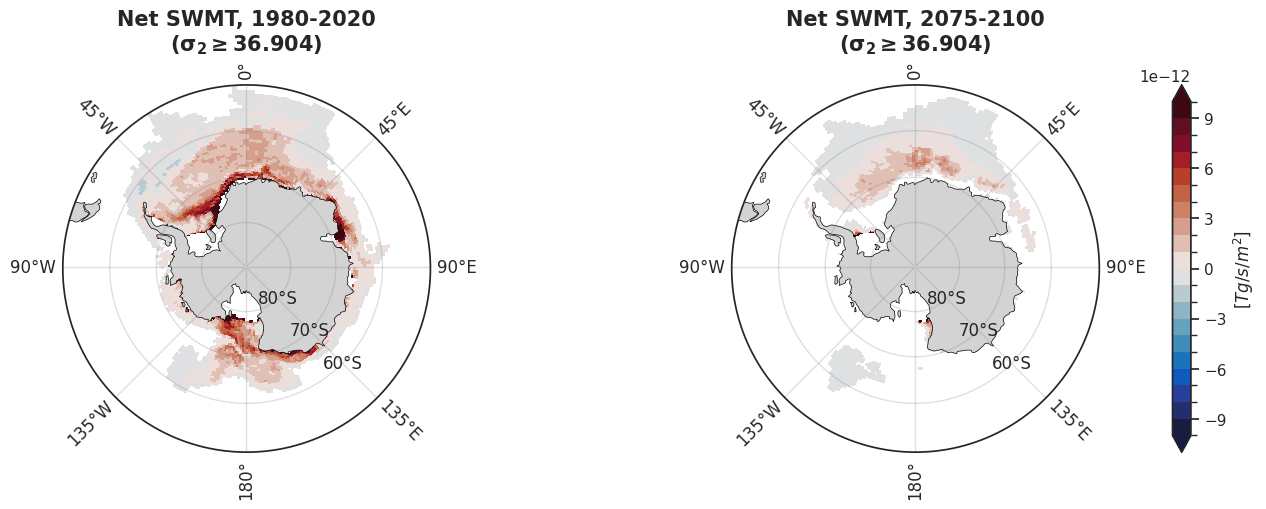

In [59]:
density_title = f"$\\mathbf{{(\\sigma_2 \\geq {sigma0})}}$"
cmap = cmo.balance; plt.get_cmap('Spectral_r')
boundaries = 1e-12 * np.arange(-10, 10 + 0.1,1)
boundaries[np.abs(boundaries) < 1e-16]  = 0
norm = BoundaryNorm(boundaries, ncolors=cmap.N, clip=False)

times_list = [daterange2tuple(reference_period), daterange2tuple(pert_period)]
nt = len(times_list)

fig, ax = plt.subplots(1, nt, figsize = (15, 5),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
[a.set_extent([-180, 180, -90, -50], ccrs.PlateCarree()) for a in ax.flatten()]
width = 0.25

mean_swmt = dict()
for (i, times) in enumerate(times_list):
    curr_width = 0.0

    var = ds_sfc_SWMT_fixed.sel(year = slice(times[0], times[1])).sel(exp = "forced").mean("year")
    print(var["SWMT"].sum().compute().values)
    var_masked = var.where(np.abs(var["SWMT"]) > 1e-1)
    mean_swmt['-'.join(list(map(str, times)))] = var_masked.compute()
    print(var_masked["SWMT"].sum().compute().values)
    
    var_convert = var_masked["SWMT"] * mass_flux_units_conversion
    cm = plot_antarctic(var_convert, ax[i], 
                        cmap = cmap, norm = norm, mask_threshold = 1e-50)
        
    ax[i].set_title("Net SWMT, " + '-'.join(list(map(str, times))) + "\n" + density_title, 
                 fontweight = "bold", fontsize = 15, ha='center')


fig.tight_layout()
fig.colorbar(cm, ax = ax[:], label = f"[{mass_flux_units}]", fraction = 0.02, extend = "both")

In [60]:
ds_diff_decomp = get_variable_spatial_decompose(mean_swmt, var = "SWMT") 
ds_ref_sum = toTg * get_variable_spatial_sum_reference(mean_swmt, var = "SWMT") 
ds_pert_sum =  toTg * get_variable_spatial_sum_pert(mean_swmt, var = "SWMT") 

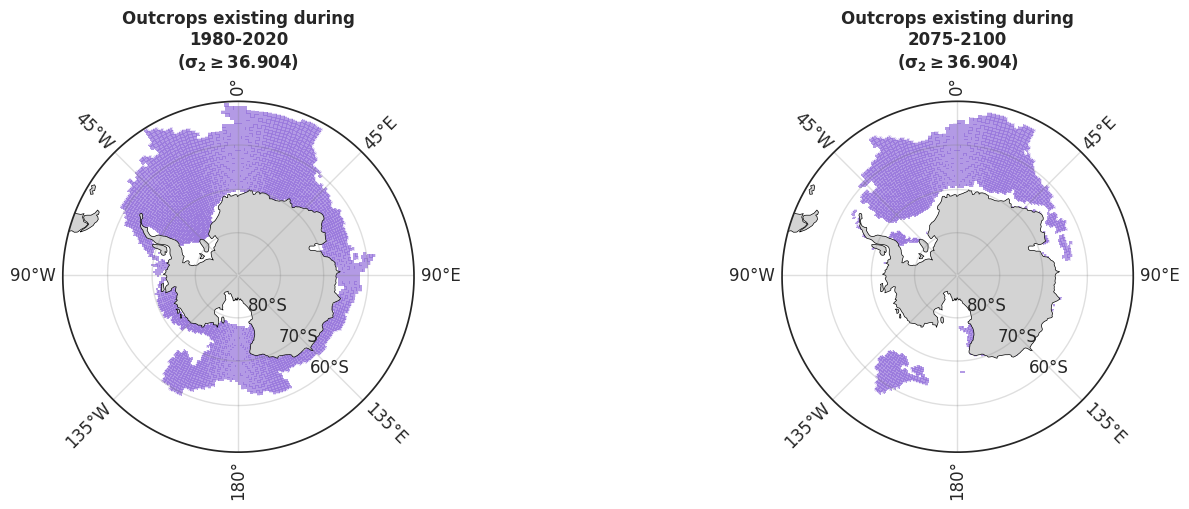

In [73]:
base = ListedColormap(['white','mediumpurple'])
colors = base(np.linspace(0, 1, base.N))
colors[:, -1] = 0.7        # set all alphas to
cmap = ListedColormap(colors)

regions = ["D_f", "D_g"]
nr = len(regions)

fig, ax = plt.subplots(1, nr, figsize = (15, 5),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
[a.set_extent([-180, 180, -90, -50], ccrs.PlateCarree()) for a in ax.flatten()]

for (i, region) in enumerate(regions):
    cm = plot_antarctic(1.0 * ds_diff_decomp[region], ax[i], 
                        cmap = cmap, norm = None, mask_threshold = -np.inf)
        


ax[0].set_title("Outcrops existing during\n" + '-'.join(list(map(str, times_list[0]))) + "\n" + density_title, 
             fontweight = "bold", fontsize = 12, ha='center')

ax[1].set_title("Outcrops existing during\n" + '-'.join(list(map(str, times_list[1]))) + "\n" + density_title, 
             fontweight = "bold", fontsize = 12, ha='center')

fig.tight_layout()

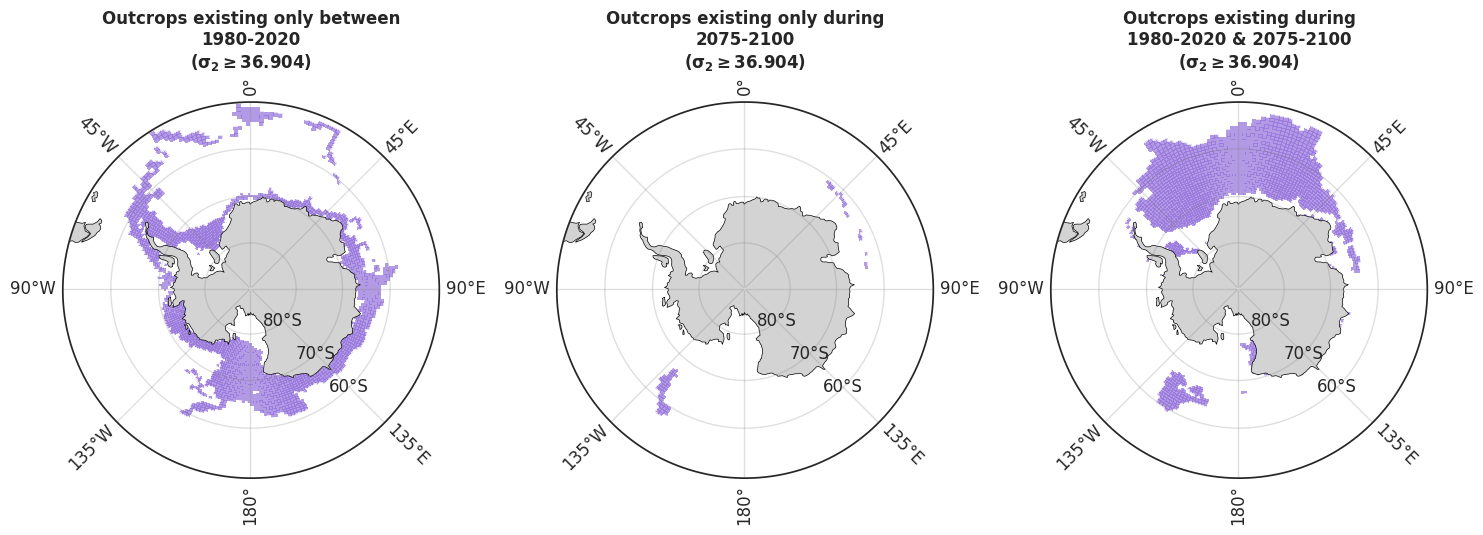

In [61]:
base = ListedColormap(['white','mediumpurple'])
colors = base(np.linspace(0, 1, base.N))
colors[:, -1] = 0.7        # set all alphas to
cmap = ListedColormap(colors)

regions = ["D_f_minus_g", "D_g_minus_f", "D_intersect"]
nr = len(regions)

fig, ax = plt.subplots(1, nr, figsize = (15, 5),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
[a.set_extent([-180, 180, -90, -50], ccrs.PlateCarree()) for a in ax.flatten()]

for (i, region) in enumerate(regions):
    cm = plot_antarctic(1.0 * ds_diff_decomp[region], ax[i], 
                        cmap = cmap, norm = None, mask_threshold = -np.inf)
        


ax[0].set_title("Outcrops existing only between\n" + '-'.join(list(map(str, times_list[0]))) + "\n" + density_title, 
             fontweight = "bold", fontsize = 12, ha='center')

ax[1].set_title("Outcrops existing only during\n" + '-'.join(list(map(str, times_list[1]))) + "\n" + density_title, 
             fontweight = "bold", fontsize = 12, ha='center')


ax[2].set_title("Outcrops existing during both\n" + '-'.join(list(map(str, times_list[0]))) + " & " + '-'.join(list(map(str, times_list[1]))) + "\n" +  density_title, 
             fontweight = "bold", fontsize = 12, ha='center')

fig.tight_layout()

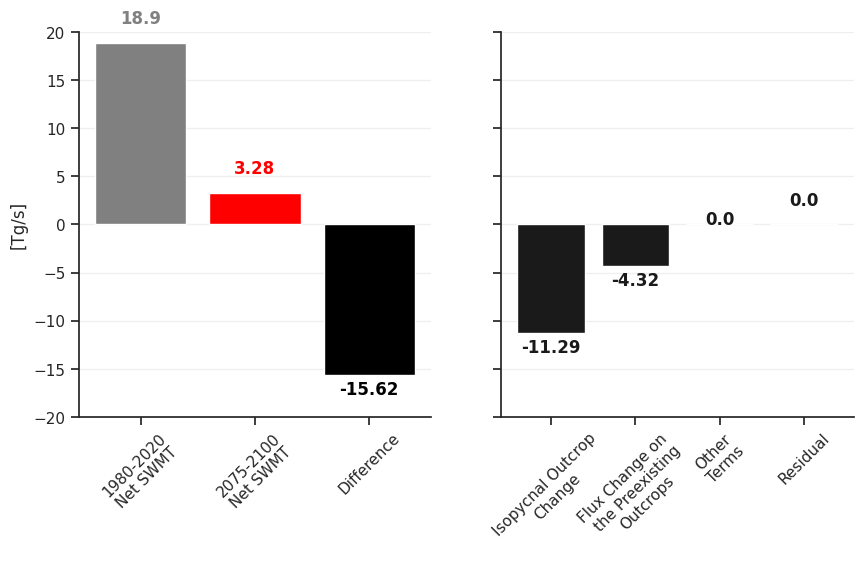

In [62]:
outcrop_shift = toTg * ds_diff_decomp["domain_shift"]
flux_change_on_preexist_outcrop = toTg * ds_diff_decomp["integrand_change"]
true_diff = toTg * ds_diff_decomp["true_total"]
residual = true_diff - (toTg *  ds_diff_decomp["reconstructed_total"])
other_terms = (true_diff - residual) - (outcrop_shift + flux_change_on_preexist_outcrop)

fig, ax = plt.subplots(1, 2, figsize = (10, 5), sharey = True)

lab_to_data = {
    reference_period + "\nNet SWMT": ds_ref_sum,
    pert_period + "\nNet SWMT":  ds_pert_sum,
    "Difference": true_diff,
}

labs = [k for k in lab_to_data.keys()]
bars = ax[0].bar(labs, [lab_to_data[k].values for k in labs], color = ["grey", "red", "black"])
add_bar_numbers(bars, ax[0])
ax[0].tick_params(axis='x', labelrotation=45, labelright=False)
ax[0].set_ylabel("[Tg/s]")
lab_to_data = {
    "Isopycnal Outcrop\nChange": outcrop_shift,
    "Flux Change on\n the Preexisting\nOutcrops":  flux_change_on_preexist_outcrop,
    "Other\nTerms":  other_terms,
    "Residual":  residual,

}

labs = [k for k in lab_to_data.keys()]
bars= ax[1].bar(labs, [lab_to_data[k].values for k in labs], color = "k")
add_bar_numbers(bars, ax[1])
ax[1].tick_params(axis='x', labelrotation=45, labelright=False)
for a in ax: 
    a.set_ylim(-20, 20)
    a.grid(alpha = 0.3)
    a.xaxis.grid(False)
    a.spines["top"].set_visible(False)
    a.spines["right"].set_visible(False)

In [65]:
SWMT_var_to_label = {
    # heat budget
    "SWMT":             "net surface transformation",

    "SWMT_heat":             "heat",
    "SWMT_heat_latent":      "latent heat flux",
    "SWMT_heat_frazil":      "frazil",
    "SWMT_heat_longwave":    "longwave",
    "SWMT_heat_shortwave":   "shortwave heat flux",
    "SWMT_heat_mass_transfer":"mass transfer",
    "SWMT_heat_sensible":    "sensible heat flux",
    "SWMT_salt_residual":    "salt residual",
    "SWMT_residual":    "residual",

    # salt budget
    "SWMT_salt":             "salt",
    "SWMT_salt_evaporation": "evap",
    "SWMT_salt_precipitation":"precip",
    "SWMT_salt_rivers":      "rivers",
    "SWMT_salt_icebergs":    "icebergs",
    "SWMT_salt_basal_salt":  "basal salt",
    "SWMT_salt_sea_ice":     "sea ice freeze/melt flux",
    "SWMT_heat_residual":    "heat residual",
    "SWMT_salt_precip_minus_evaporation": "precip/evap"
}

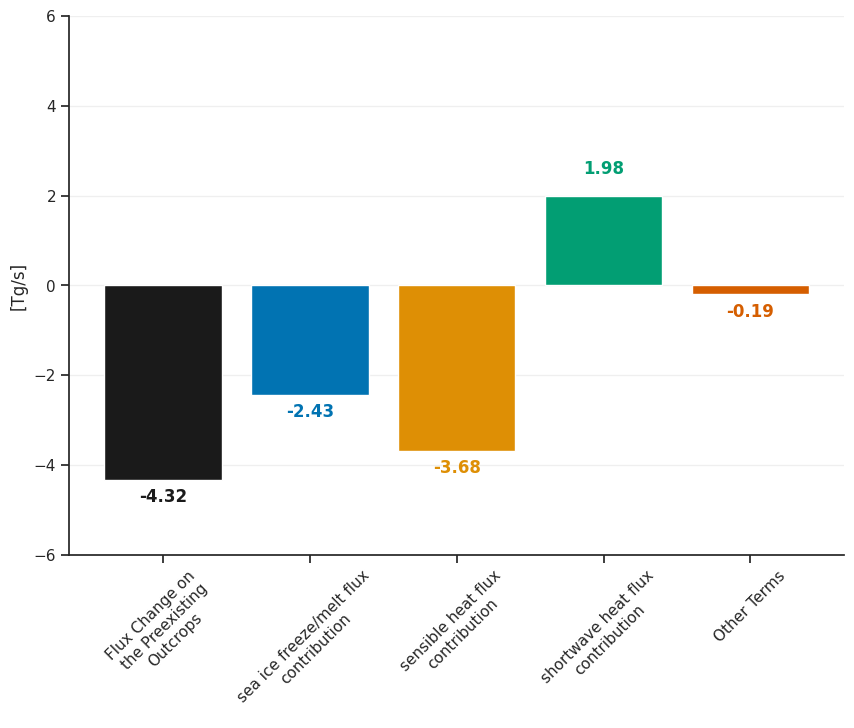

In [66]:
# exclude_vars = {"boundary_fluxes_heat", "SWMT", "SWMT_salt_approx", "SWMT_heat_approx", "SWMT_heat", "SWMT_salt", "SWMT_heat_residual", "SWMT_salt_residual"}
# decomp_vars = sorted(list(set(ds_sfc_SWMT.data_vars) - exclude_vars))

decomp_vars = ["SWMT_salt_sea_ice", "SWMT_heat_sensible", "SWMT_heat_shortwave"]
decomp_labels = [SWMT_var_to_label[var] + "\ncontribution" for var in decomp_vars]
decomp_integrand_change = [toTg * get_variable_integrand_change(mean_swmt, var = var).values for var in decomp_vars]

decomp_integrand_change += [toTg * get_variable_integrand_change(mean_swmt, var = "SWMT").values - np.sum(decomp_integrand_change)]
decomp_labels += ["Other Terms"]

decomp_integrand_change = [flux_change_on_preexist_outcrop] + decomp_integrand_change
decomp_labels = ["Flux Change on\n the Preexisting\nOutcrops"] + decomp_labels
colors= ["k"] + sns.color_palette("colorblind", len(decomp_integrand_change)-1)

fig, ax = plt.subplots(figsize = (10, 7))
bars = ax.bar(decomp_labels, decomp_integrand_change, align='center', color = colors)
ax.tick_params(axis='x', labelrotation=45, labelright=False)

ax.set_ylim(-6, 6)
ax.set_ylabel("[Tg/s]")
ax.grid(alpha = 0.3)
ax.xaxis.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

add_bar_numbers(bars, ax, text_height_factor = 0.5)


In [67]:
ds_sfc_sigma_geq = ds_sfc_props.sel(exp = "forced")
ds_sfc_sigma_geq_thermo = get_sigma2_at_surface(ds_sfc_sigma_geq, keep_vars = False)

In [68]:
for var in ["fsitherm", "hfsso", "rsdoabsorb"]:
    try:
        ds_sfc_sigma_geq_thermo[var] = ds_sfc_sigma_geq_thermo[var].where(ds_sfc_sigma_geq.sigma2_l >= sigma0)
        ds_sfc_sigma_geq_thermo[var] = ds_sfc_sigma_geq_thermo[var].sum("sigma2_l", skipna = True)
    except: 
        print(f"Summing {var} failed")

ds_sfc_sigma_geq_thermo["sigma_mask"] = (np.abs(ds_sfc_sigma_geq_thermo.hfsso) > 0.0)

In [69]:
def area_weighted_average(ds, mask):
    weights = (ds.areacello * ds.wet).where((ds.wet > 0) * (mask > 0))
    weighted_ds = (ds * weights).sum(["xh", "yh"], skipna = True) / weights.sum(["xh", "yh"], skipna = True)
    return weighted_ds
def area_weighted_sum(ds, mask):
    weights = (ds.areacello * ds.wet).where((ds.wet > 0) * (mask > 0))
    weighted_ds = (ds * weights).sum(["xh", "yh"], skipna = True)
    return weighted_ds

In [70]:
average_period = lambda ds, period_slice: ds.sel(year = period_slice).mean("year")
get_baselines = lambda ds, var: average_period(ds[var], slice(reference_period[0], reference_period[1]))
get_anomaly = lambda ds, var: average_period(ds[var], slice(pert_period[0], pert_period[1])) - ds[f"{var}_baseline"]
get_anomaly_ts = lambda ds, var: ds[var] - ds[f"{var}_baseline"]


ds_sigma_sfc_decomp = ds_sfc_sigma_geq_thermo[["rho2", "ct", "sa"]]
ds_sigma_sfc_decomp["rho2_baseline"] = get_baselines(ds_sigma_sfc_decomp, "rho2")
ds_sigma_sfc_decomp["ct_baseline"] = get_baselines(ds_sigma_sfc_decomp, "ct")
ds_sigma_sfc_decomp["sa_baseline"] = get_baselines(ds_sigma_sfc_decomp, "sa")


p_ref = 2000 #2000 dbar reference pressure 

# Calculate thermal expansion coefficient alpha (1/K) at reference pressure
ds_sigma_sfc_decomp['alpha_baseline'] = xr.apply_ufunc(
    gsw.alpha, ds_sigma_sfc_decomp["sa_baseline"], ds_sigma_sfc_decomp["ct_baseline"], p_ref, dask="parallelized"
)

# Calculate the haline contraction coefficient beta (kg/g) at reference pressure
ds_sigma_sfc_decomp['beta_baseline'] = xr.apply_ufunc(
    gsw.beta, ds_sigma_sfc_decomp["sa_baseline"], ds_sigma_sfc_decomp["ct_baseline"], p_ref, dask="parallelized"
)


ds_sigma_sfc_decomp["rho2_anomaly"] = get_anomaly_ts(ds_sigma_sfc_decomp, "rho2")
ds_sigma_sfc_decomp["ct_anomaly"] = get_anomaly_ts(ds_sigma_sfc_decomp, "ct")
ds_sigma_sfc_decomp["sa_anomaly"] = get_anomaly_ts(ds_sigma_sfc_decomp, "sa")

rho0 = ds_sigma_sfc_decomp["rho2_baseline"] + 1000  # 
ds_sigma_sfc_decomp["rho2_anomaly_ct_contrib"] = -rho0 * ds_sigma_sfc_decomp['alpha_baseline'] * ds_sigma_sfc_decomp["ct_anomaly"]
ds_sigma_sfc_decomp["rho2_anomaly_sa_contrib"] =  rho0 * ds_sigma_sfc_decomp['beta_baseline']  * ds_sigma_sfc_decomp["sa_anomaly"]

ds_sigma_sfc_decomp["rho2_anomaly_recon"] = ds_sigma_sfc_decomp["rho2_anomaly_ct_contrib"] + ds_sigma_sfc_decomp["rho2_anomaly_sa_contrib"]

In [ ]:
region_of_interest = ds_diff_decomp["D_f"]
dens_region = density_title.replace('(', '').replace(')', '').replace('\\mathbf', '')

fig, axes = plt.subplots(1, 3, figsize = (13, 5))
temp_color = "red"
sal_color = "green"
ax = axes[0]
area_weighted_average(ds_sigma_sfc_decomp["rho2_anomaly"], region_of_interest).plot(ax=ax, c= "k")

ct_contrib = ds_sigma_sfc_decomp["rho2_anomaly_ct_contrib"]# + ds_sigma_sfc_decomp["rho2_baseline"]
area_weighted_average(ct_contrib, ds_diff_decomp["D_f"]).plot(ax=ax, label= "temperature contribution", c = temp_color)

sa_contrib = ds_sigma_sfc_decomp["rho2_anomaly_sa_contrib"]# + ds_sigma_sfc_decomp["rho2_baseline"]

area_weighted_average(sa_contrib, ds_diff_decomp["D_f"]).plot(ax=ax, label= "salinity contribution", c = sal_color)
ax.legend()
ax.set_title(f"Density Anomaly")
ax.set_ylabel(r"$[m^3/kg]$")

ax = axes[1]
# plot temperature
temp_line = area_weighted_average(ds_sigma_sfc_decomp["ct_anomaly"], region_of_interest).plot(ax=ax, color=temp_color)
# label and color the left y‑axis for temperature
ax.set_title("Conservative Temperature Anomaly ")
ax.set_ylabel(r"$[deg C]$")

# twin for salinity
axt = axes[2]
salt_line = area_weighted_average(ds_sigma_sfc_decomp["sa_anomaly"], region_of_interest).plot(ax=axt, color=sal_color)
# label and color the right y‑axis for salinity
axt.set_title("Abs. Salinity Anomaly")
axt.set_ylabel(r"$ [g/kg]$")

fig.suptitle(f"Surface Thermodynamic Variable Anomalies in {reference_period} " + dens_region + " region")

fig.tight_layout()

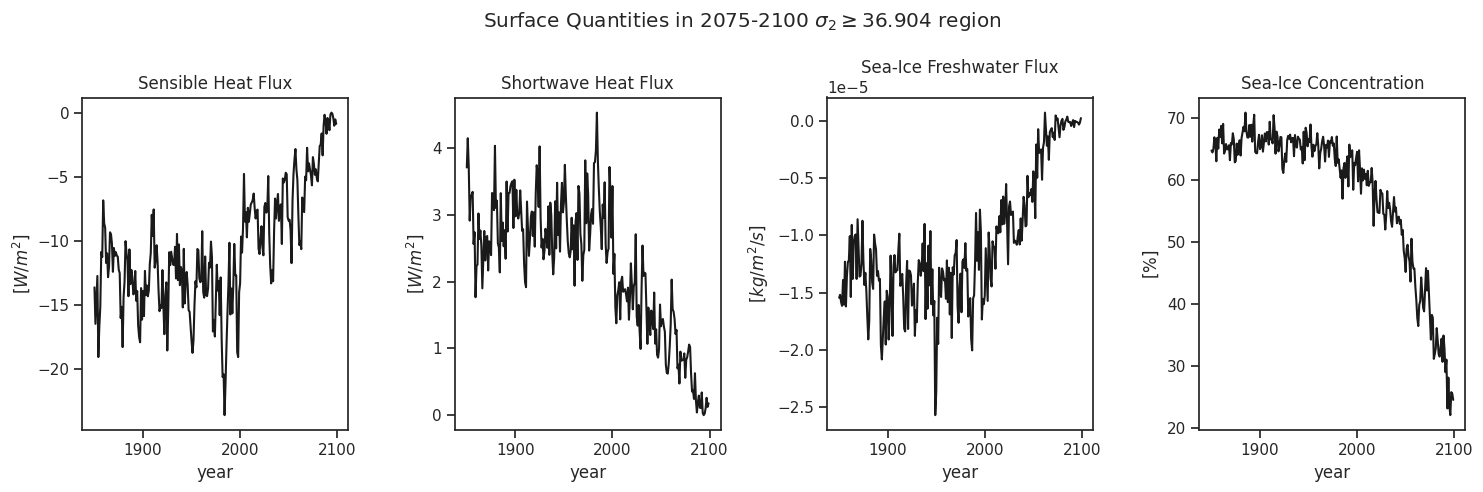

In [72]:
dens_region = density_title.replace('(', '').replace(')', '').replace('\\mathbf', '')

fig, axes = plt.subplots(1, 4, figsize = (15, 5))

ax = axes[0]
area_weighted_average(ds_sfc_sigma_geq_thermo["hfsso"], ds_diff_decomp["D_intersect"]).plot(ax=ax, c= "k")
ax.set_title(f"Sensible Heat Flux")
ax.set_ylabel(r"$[W/m^2]$")

ax = axes[1]
area_weighted_average(ds_sfc_sigma_geq_thermo["rsdoabsorb"], ds_diff_decomp["D_intersect"]).plot(ax=ax, c= "k")
ax.set_title(f"Shortwave Heat Flux")
ax.set_ylabel(r"$[W/m^2]$")

ax = axes[2]
area_weighted_average(ds_sfc_sigma_geq_thermo["fsitherm"], ds_diff_decomp["D_intersect"]).plot(ax=ax, c= "k")
ax.set_title(f"Sea-Ice Freshwater Flux")
ax.set_ylabel(r"$[kg/m^2/s]$")

ax = axes[3]
area_weighted_average(100 * ds_sfc_sigma_geq_thermo["siconc"], ds_diff_decomp["D_intersect"]).plot(ax=ax, c= "k")
ax.set_title(f"Sea-Ice Concentration")

fig.suptitle(f"Surface Quantities in {pert_period} " + dens_region + " region")

ax.set_ylabel(r"$[\%]$") 
fig.tight_layout()